# Comparing 2 Random Forest Models

Prepare data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

bin_count = 171
def create_test_train(data_set_path, test_size=0.10):
    """ Splits a given csv file into testing and training. Target column is all the bins."""
    # Make sure the columns are set
    data_set = pd.read_csv(data_set_path)

    # Shuffle the data
    data_set = data_set.sample(frac=1, random_state=0)
 
    # Select all except output bins
    data_set_X = data_set.drop([f'Output_Bin_{i}' for i in range(bin_count)], axis=1)
    
    # Select only the output bins
    data_set_Y = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]]

    #Split into training and test data
    return train_test_split(data_set_X,
                            data_set_Y,
                            test_size=test_size, 
                            random_state=300)

filename= "/project/SDS-capstones-kropko21/uva-astronomy/dust_training_data_all_bins_v2.csv"
X_train, X_test, y_train, y_test = create_test_train(filename, test_size=0.10)

def evaluate_fit(y_samples, y_test):
    ent = []
    js_list = []

    # Turn all negative preds to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    
    y_samples_obs = y_samples
    y_test_obs = y_test
    
    # Small constant to prevent inf for 0s
    c = 1e-100
    
    y_test_obs += c
    y_samples_obs += c

    fits = []
    for i in range(len(y_test_obs)):
        # Calcuate the two entropy measures
        e = entropy(y_test_obs.iloc[i], y_samples_obs[i])
        js = jensenshannon(y_test_obs.iloc[i], y_samples_obs[i])
        ent.append(e if e != np.inf else 1000)
        js_list.append(js)
        # Add the index and the two entropy measures to an array to be used for plotting later
        fits.append((i, ent, js))
    #print("Entropy")
    #display(pd.DataFrame(ent).describe())
    print("Jensen-Shannon")
    display(pd.DataFrame(js_list).describe().apply(lambda s: s.apply('{0:.4f}'.format)))
    return fits, js_list

#output_is_not_end_test_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]

#X_test_non = X_test.loc[output_is_not_end_test_idx]
#y_test_non = y_test.loc[output_is_not_end_test_idx].drop(['Output_Is_End'], axis=1)


In [ ]:
#y_test_upd = y_test.drop(['Output_Is_End'], axis=1)
#y_test_upd.to_csv("true_output.csv")

In [4]:
from joblib import dump, load
import numpy as np
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import binned_statistic

def fit_for_model(filename, X_test, y_test):
    """ Loads and fits model from file. Evaluates against X,y test"""
    
    rf = load(filename)
    import time # Just to compare fit times
    start = time.time()
    preds = rf.predict(X_test)
    end = time.time()
    print(f"Tune Fit Time: {end - start} \n Seconds per pred: {(end-start)/len(X_test)}")
    
    
    
    # Renormalize samples
    preds_normalized = []
    for s in preds:
        preds_normalized.append(np.divide(s,np.sum(s)))
        
    preds_df = pd.DataFrame(preds_normalized, columns=[f'Output_Bin_{i}' for i in range(bin_count)])
    preds_df.to_csv("preds_small_model.csv")
    
    return evaluate_fit(preds_normalized, y_test), preds_normalized

def model_js_spread(js_list):
    """ Displays the counts and percentages of the js entropy for the predictions by 0.1 """
    bin_counts = binned_statistic(js_list, js_list, statistic='count', bins=10, range=(0, 1))
    print(pd.DataFrame({"<js":bin_counts[1][1:], "count":bin_counts[0], "percent":(bin_counts[0]/sum(bin_counts[0]))}))
    

def compare_two_models(model_1_name, model_2_name):
    """ Takes in the file names of two models and displays the fits and descriptive stats on the fits"""
    print("Model 1 Fit:")
    m1_fit, model_1_preds = fit_for_model(model_1_name, X_test, y_test)
    model_1_fits, model_1_js_list = m1_fit
    print("Model 2 Fit:")
    m2_fit, model_2_preds = fit_for_model(model_2_name, X_test, y_test)
    model_2_fits, model_2_js_list = m2_fit

    fits_1_sorted = sorted(model_1_fits, key=lambda a: float(a[2]), reverse=True)
    fits_2_sorted = sorted(model_2_fits, key=lambda a: float(a[2]), reverse=True)


    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 16))
    
    # Plots the best, 25%, 50%, 75%, and worst fits for each model 
    for idx, ax in enumerate(axes.flatten()):
        preds = model_1_preds if idx < 5 else model_2_preds
        model_idxs = fits_1_sorted if idx < 5 else fits_2_sorted
        actual_idx = idx % 5
        if actual_idx == 4:
            i = model_idxs[0][0]
        elif actual_idx == 0:
            i = model_idxs[-1][0]
        else:
            i = model_idxs[int(len(preds)/25)*(5-actual_idx)][0]

        test_pred = preds[i]
        true = y_test.iloc[i]
        ax.plot(test_pred, color='blue', label='pred')
        ax.plot(true, color='orange', label='true')
        ax.xaxis.set_visible(False)
        ax.legend(loc="upper left")

        jc = jensenshannon(true, test_pred)
        ax.set_title(jc)
    
    plt.show()
    
    print("Model 1 Spread")
    model_js_spread(model_1_js_list)
    print("Model 2 Spread")
    model_js_spread(model_2_js_list)
    
    

    
    
    



Compare current large to 512 (2.6GB)

Model 1 Fit:


/home/keh4nb/.local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Tune Fit Time: 82.87654638290405 
 Seconds per pred: 0.0005822844543167573
Jensen-Shannon


,0
count,142330.0000
mean,0.0803
std,0.1214
min,0.0000
25%,0.0052
50%,0.0195
75%,0.1081
max,0.8159


Model 2 Fit:
Tune Fit Time: 50.47993993759155 
 Seconds per pred: 0.0003546683056108449
Jensen-Shannon


,0
count,142330.0000
mean,0.0992
std,0.1340
min,0.0008
25%,0.0119
50%,0.0296
75%,0.1468
max,0.8161


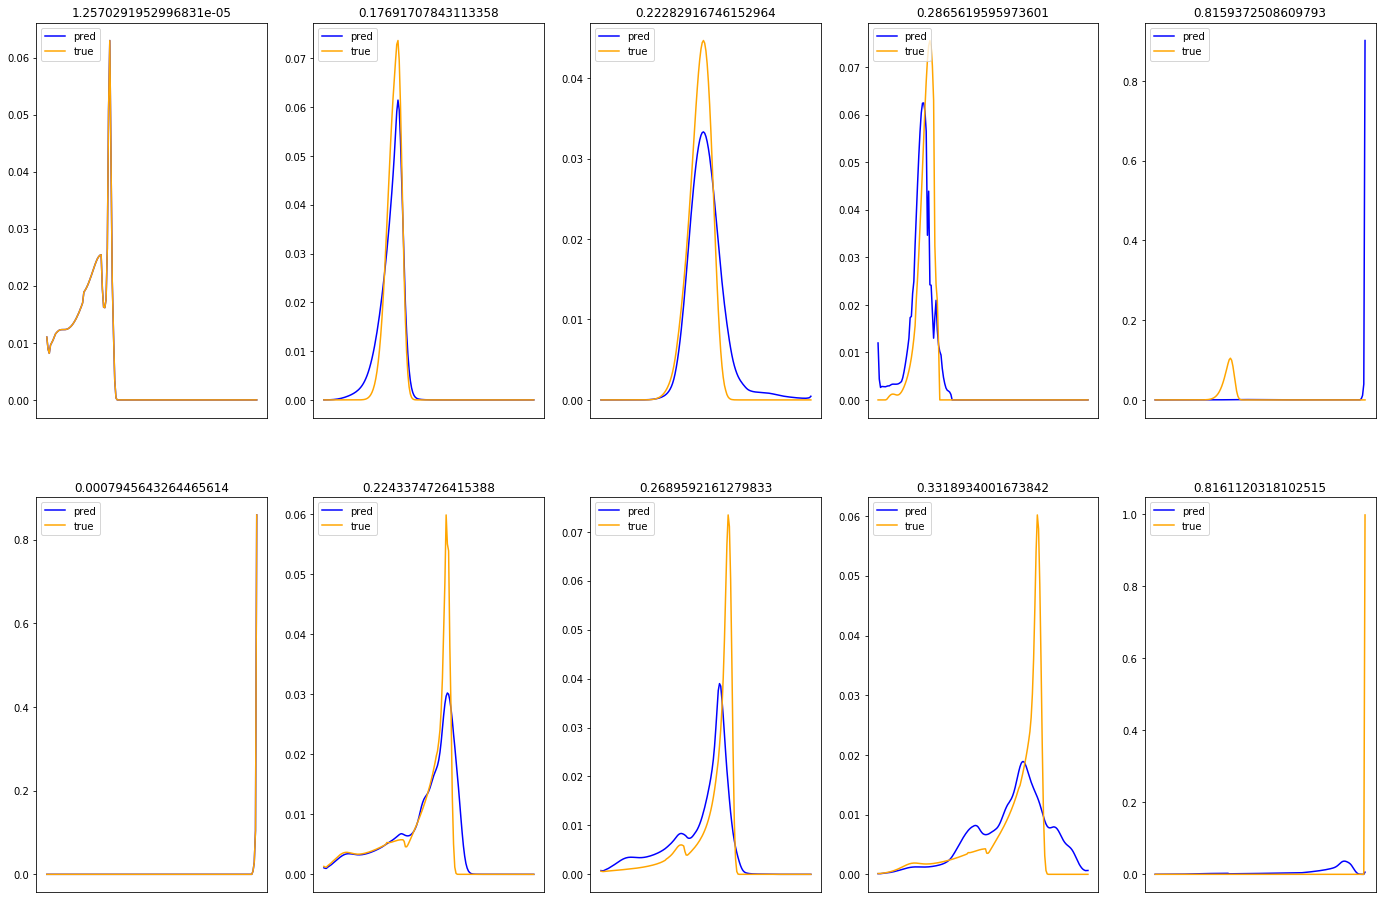

Model 1 Spread
   <js     count   percent
0  0.1  104698.0  0.735600
1  0.2   18075.0  0.126994
2  0.3    9132.0  0.064161
3  0.4    4960.0  0.034849
4  0.5    3356.0  0.023579
5  0.6    1615.0  0.011347
6  0.7     427.0  0.003000
7  0.8      62.0  0.000436
8  0.9       5.0  0.000035
9  1.0       0.0  0.000000
Model 2 Spread
   <js    count   percent
0  0.1  97552.0  0.685393
1  0.2  18383.0  0.129158
2  0.3  12411.0  0.087199
3  0.4   6746.0  0.047397
4  0.5   4053.0  0.028476
5  0.6   2386.0  0.016764
6  0.7    693.0  0.004869
7  0.8    104.0  0.000731
8  0.9      2.0  0.000014
9  1.0      0.0  0.000000


In [5]:
model_1_name = '/project/SDS-capstones-kropko21/uva-astronomy/rf-model-single-all-depth-30-trees-1000-min_samps-256.joblib'
model_2_name = '/project/SDS-capstones-kropko21/uva-astronomy/rf-model-single-all-depth-30-trees-1000-min_samps-512.joblib'
compare_two_models(model_1_name, model_2_name)

Compare current large to 1024 (1.2GB)

Model 1 Fit:
Jensen-Shannon


,0
count,142330.0000
mean,0.0803
std,0.1214
min,0.0000
25%,0.0052
50%,0.0195
75%,0.1081
max,0.8159


Model 2 Fit:
Jensen-Shannon


,0
count,142330.0000
mean,0.1189
std,0.1453
min,0.0009
25%,0.0205
50%,0.0435
75%,0.1891
max,0.8217


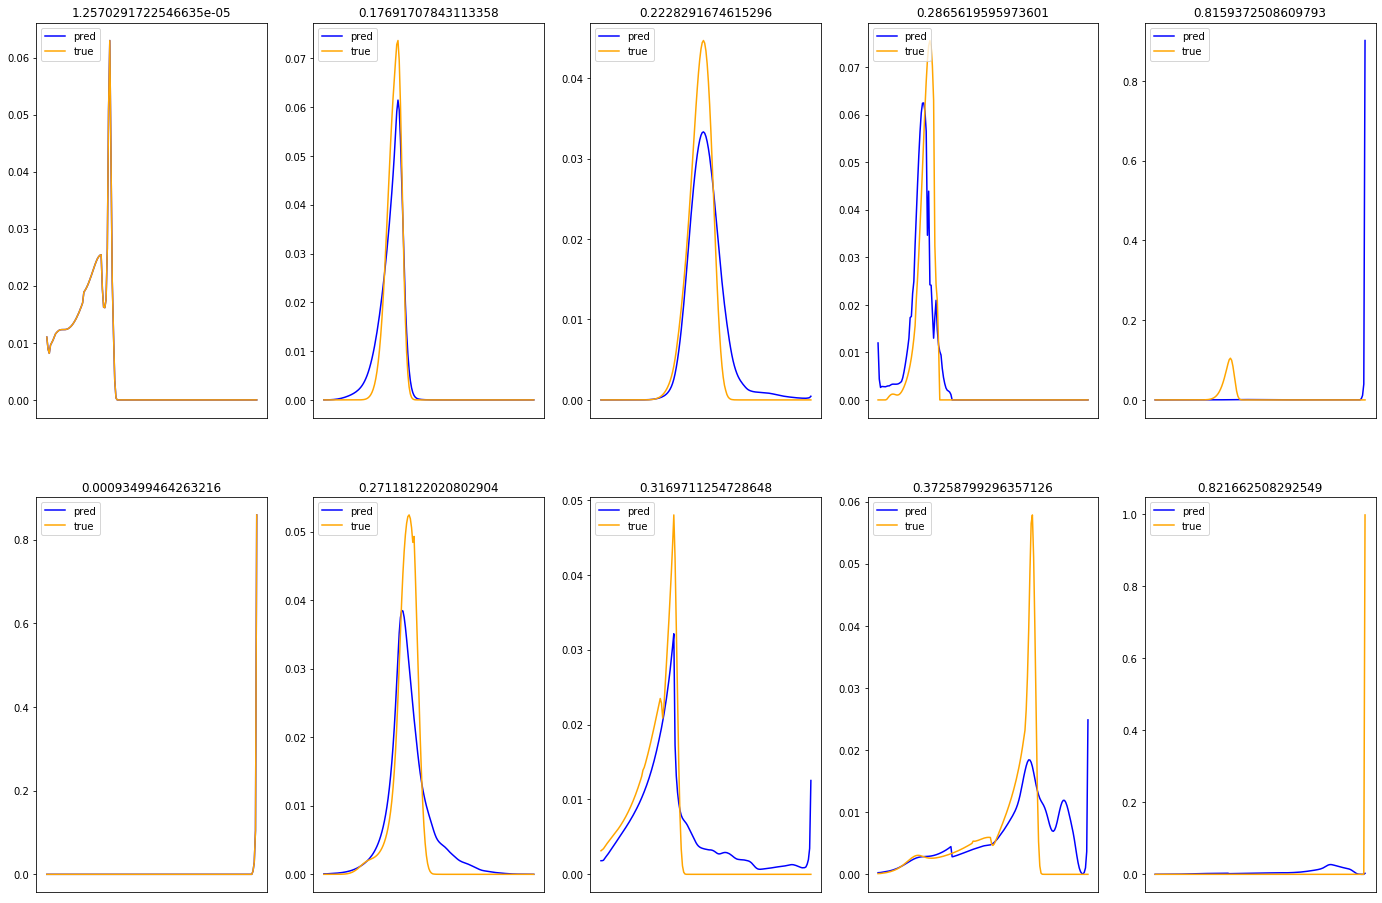

Model 1 Spread
   <js     count   percent
0  0.1  104698.0  0.735600
1  0.2   18075.0  0.126994
2  0.3    9132.0  0.064161
3  0.4    4960.0  0.034849
4  0.5    3356.0  0.023579
5  0.6    1615.0  0.011347
6  0.7     427.0  0.003000
7  0.8      62.0  0.000436
8  0.9       5.0  0.000035
9  1.0       0.0  0.000000
Model 2 Spread
   <js    count   percent
0  0.1  92393.0  0.649146
1  0.2  16056.0  0.112808
2  0.3  14860.0  0.104405
3  0.4   9643.0  0.067751
4  0.5   5092.0  0.035776
5  0.6   3085.0  0.021675
6  0.7   1040.0  0.007307
7  0.8    158.0  0.001110
8  0.9      3.0  0.000021
9  1.0      0.0  0.000000


In [8]:
model_3_name = '/project/SDS-capstones-kropko21/uva-astronomy/rf-model-single-all-depth-30-trees-1000-min_samps-256.joblib'
model_4_name = '/project/SDS-capstones-kropko21/uva-astronomy/rf-model-single-all-depth-30-trees-1000-min_samps-1024.joblib'
compare_two_models(model_3_name, model_4_name)

In [ ]:
fit_for_model('/project/SDS-capstones-kropko21/uva-astronomy/rf-model-single-all-depth-30-trees-1000-min_samps-2048.joblib', X_test, y_test)

Store the bad fit data

In [4]:
model_name = '/project/SDS-capstones-kropko21/uva-astronomy/rf-model-single-all-depth-30-trees-1000-min_samps-2048.joblib'
m1_fit, model_1_preds = fit_for_model(model_name, X_test, y_test)
fits, model_1_js_list = m1_fit

fits_bad_idx = list(map(lambda f: f[0],filter(lambda f: f[2] > 0.3, fits)))
print(len(fits_bad_idx))
print(len(X_test))
df_inputs_bad = X_test.iloc[fits_bad_idx]
display(df_inputs_bad.describe())
display(X_test.describe())

/home/keh4nb/.local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Jensen-Shannon


,0
count,142330.0000
mean,0.1414
std,0.1560
min,0.0009
25%,0.0321
50%,0.0617
75%,0.2296
max,0.8229


25247
142330


,R,Mstar,alpha,d2g,sigma,Tgas,Input_Bin_0,Input_Bin_1,Input_Bin_2,Input_Bin_3,...,Input_Bin_163,Input_Bin_164,Input_Bin_165,Input_Bin_166,Input_Bin_167,Input_Bin_168,Input_Bin_169,Input_Bin_170,t,Delta_t
count,25247.000000,25247.0,25247.000000,25247.000000,25247.000000,25247.000000,2.524700e+04,2.524700e+04,2.524700e+04,2.524700e+04,...,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,2.524700e+04,2.524700e+04
mean,59.840781,1.0,0.006836,0.151751,424.857493,37.187883,1.666328e-03,1.380927e-03,1.315725e-03,1.761732e-03,...,0.000420,0.000398,0.000370,0.000343,0.000325,0.000296,0.000261,0.000640,1.551683e+12,7.943973e+12
std,100.135900,0.0,0.023496,0.332538,1194.198226,34.221191,7.227039e-03,4.730640e-03,3.999616e-03,1.088562e-02,...,0.004465,0.004402,0.004316,0.004288,0.004407,0.004402,0.004431,0.011700,3.386509e+12,9.027149e+12
min,0.316228,1.0,0.000010,0.000100,0.152053,4.472136,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,4.115553,1.0,0.000010,0.000100,3.287778,12.459038,0.000000e+00,0.000000e+00,2.515551e-29,1.852004e-26,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.705980e+10,7.323577e+11
50%,15.548407,1.0,0.000100,0.010000,27.728098,25.360456,1.549367e-09,4.489599e-09,1.166551e-08,3.719345e-08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.781622e+11,3.938564e+12
75%,64.421522,1.0,0.001000,0.100000,203.613562,49.293077,4.147657e-04,4.879315e-04,5.553529e-04,7.733183e-04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.334668e+12,1.284190e+13
max,500.000000,1.0,0.100000,1.000000,9559.802528,177.827941,8.196002e-02,4.912551e-02,3.916366e-02,3.978454e-01,...,0.074758,0.076999,0.077552,0.080529,0.095494,0.123620,0.208613,0.489186,3.155815e+13,3.155815e+13


,R,Mstar,alpha,d2g,sigma,Tgas,Input_Bin_0,Input_Bin_1,Input_Bin_2,Input_Bin_3,...,Input_Bin_163,Input_Bin_164,Input_Bin_165,Input_Bin_166,Input_Bin_167,Input_Bin_168,Input_Bin_169,Input_Bin_170,t,Delta_t
count,142330.000000,142330.0,142330.000000,142330.000000,142330.000000,142330.000000,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,...,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,1.423300e+05,1.423300e+05
mean,71.090053,1.0,0.016234,0.173895,640.153803,40.139232,4.592101e-03,3.472996e-03,3.122440e-03,3.487101e-03,...,0.000889,0.000753,0.000627,0.000616,0.001691,0.004474,0.013617,0.123374,3.192120e+12,5.369616e+12
std,108.574417,0.0,0.034377,0.352409,1608.485166,41.206500,1.115014e-02,7.482049e-03,6.312950e-03,7.857879e-03,...,0.005716,0.004952,0.004345,0.004254,0.005989,0.012747,0.037780,0.299868,5.424077e+12,7.496385e+12
min,0.316228,1.0,0.000010,0.000100,0.152053,4.472136,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,3.297756,1.0,0.000100,0.001000,2.053322,10.649667,1.887126e-11,8.027441e-11,2.974363e-10,1.258899e-09,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.812078e+10,1.514678e+11
50%,19.404190,1.0,0.001000,0.010000,19.888666,22.701379,1.565539e-04,1.770152e-04,1.969503e-04,2.590196e-04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.583576e+11,1.551702e+12
75%,88.171443,1.0,0.010000,0.100000,283.871072,55.066914,3.570792e-03,3.409279e-03,3.408008e-03,3.916873e-03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.598521e+12,8.035090e+12
max,500.000000,1.0,0.100000,1.000000,9559.802528,177.827941,9.387390e-02,5.693502e-02,4.500693e-02,3.978454e-01,...,0.076737,0.077375,0.077552,0.080529,0.096343,0.131256,0.208613,0.999979,3.155815e+13,3.155815e+13


In [3]:
model_name = '/project/SDS-capstones-kropko21/uva-astronomy/rf-model-single-all-depth-30-trees-1000-min_samps-2048.joblib'
m1_fit, model_1_preds = fit_for_model(model_name, X_test, y_test)
fits, model_1_js_list = m1_fit
fits_1_sorted = sorted(fits, key=lambda a: float(a[2]), reverse=False)



NameError: name 'fit_for_model' is not defined

## Graphing Predictions and JS Entropies

In [1]:
# Select which entropy values to find examples
benchmarks = [ 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.30]
fits_to_plot = []
for val in fits_1_sorted:
    # If the entropy value is greater than the first in the list, store it and remove the value from benchamrks list
    if val[2] >= benchmarks[0]:
        fits_to_plot.append(val)
        _ = benchmarks.pop(0)
    if len(benchmarks) == 0:
        break
print(len(fits_to_plot))

NameError: name 'fits_1_sorted' is not defined

In [24]:
display(list(map(lambda a: a[2],fits_to_plot)))

[0.0008806148847986501,
 0.05000069596181939,
 0.10000549595522534,
 0.15000307692516557,
 0.2000198375717032,
 0.250020395489228,
 0.30000116786610037,
 0.3500165306163042,
 0.4000024664245121,
 0.45001030948763787,
 0.5000824558780906]

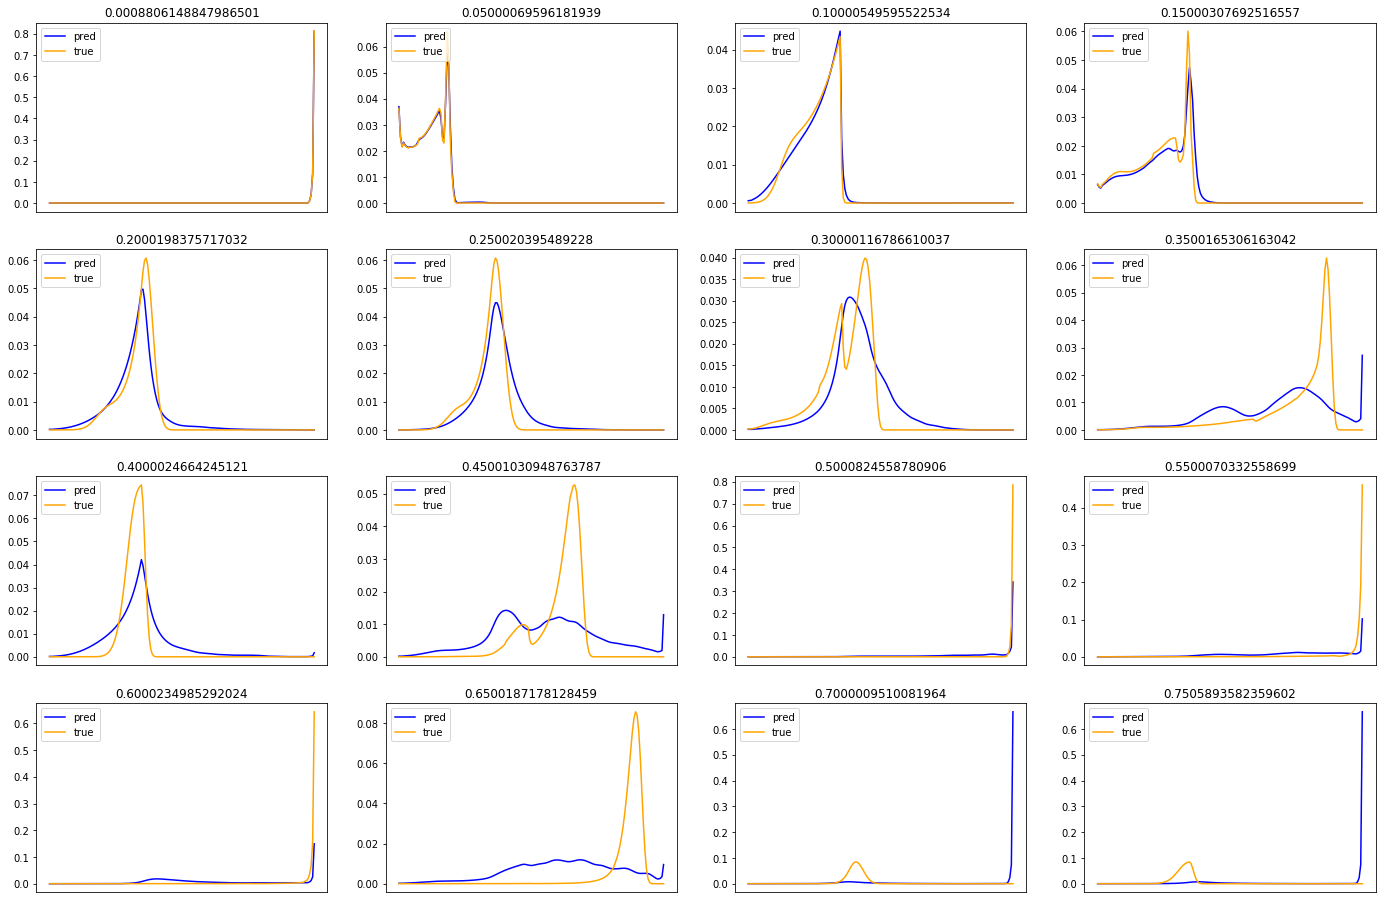

In [28]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 16))
    
for idx, ax in enumerate(axes.flatten()):
    preds = model_1_preds
    model_idxs = fits_1_sorted
    actual_idx = idx % 5
    i = fits_to_plot[idx][0]

    test_pred = preds[i]
    true = y_test.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")

    jc = jensenshannon(true, test_pred)
    ax.set_title(jc)
    
plt.show()

## Models for Plotting

In [5]:
m1_fit, model_1_preds = fit_for_model('/project/SDS-capstones-kropko21/uva-astronomy/rf-model-single-all-depth-30-trees-1000-min_samps-256.joblib', X_test, y_test)
model_1_fits, model_1_js_list = m1_fit

fits_1_sorted = sorted(model_1_fits, key=lambda a: float(a[2]), reverse=True)

/home/keh4nb/.local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Jensen-Shannon


,0
count,142330.0000
mean,0.0803
std,0.1214
min,0.0000
25%,0.0052
50%,0.0195
75%,0.1081
max,0.8159


Text(0.5, 1.0, '0.13332471041311914')

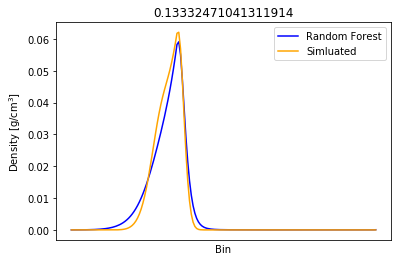

In [18]:
model_idxs = fits_1_sorted
i = model_idxs[30000][0]

test_pred = model_1_preds[i]
true = y_test.iloc[i]
plt.plot(test_pred, color='blue', label='Random Forest')
plt.plot(true, color='orange', label='Simluated')
plt.xticks([])
plt.xlabel('Bin')
plt.ylabel('Density [g/cm$^3$]')
plt.legend(loc="upper right")

jc = jensenshannon(true, test_pred)
plt.title(jc)